In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
style.use('fivethirtyeight')

In [60]:
data = pd.read_csv('/content/drive/MyDrive/Benkyou/datasets ML/OnlineRetail.csv',encoding="ISO-8859-1", header=0)
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [62]:
round(100*(data.isna().sum())/len(data),2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [63]:
data = data.dropna()
data.shape

(406829, 8)

In [64]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [65]:
data.skew()

Quantity        0.182663
UnitPrice     452.219019
CustomerID      0.029835
dtype: float64

**Recency Frequency Amount**

In [66]:
#Receny --- Happened from this day
#Frequency --- No of Customer 
#Amount --- Price

In [67]:
#Recency 
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'],format='%d-%m-%Y %H:%M')
max_date = max(data['InvoiceDate'])


In [68]:
data['Difference'] = max_date - data['InvoiceDate']
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Difference
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,373 days 04:24:00


In [69]:
feature_data = data.groupby('CustomerID')['Difference'].min().reset_index()
feature_data.head()

,CustomerID,Difference
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [70]:
feature_data['Receny'] = feature_data['Difference'].dt.days
feature_data.drop(columns=['Difference'],inplace=True)
feature_data.head()

,CustomerID,Receny
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [71]:
#monetary 
#amount = 1unit prize * total quatity eg,u buy 10 soap 10*100 =10,000
data['Amount'] = data['Quantity']*data['UnitPrice']
money = data.groupby('CustomerID')['Amount'].sum().reset_index()
money.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [72]:
#frequency no of customers
frequency = data.groupby('CustomerID')['InvoiceNo'].count().reset_index()
frequency.head()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [73]:
#MERGE
df= pd.merge(money,frequency,on='CustomerID',how='inner')


In [74]:
df= pd.merge(df,feature_data,on='CustomerID',how='inner')
df.columns = ['CustomerID','Monetary','Frequency','Recnecy']
df.head() 

,CustomerID,Monetary,Frequency,Recnecy
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


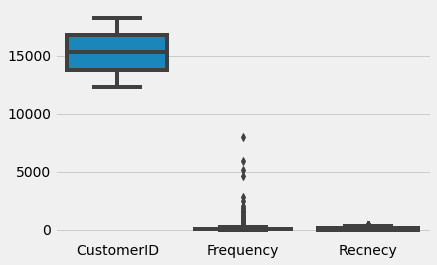

In [75]:
sns.boxplot(data=df[['CustomerID','Frequency','Recnecy']],orient='v')
plt.show()

In [76]:
class OutLierTreatment:
  def IQR(self,datacolumn):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn,[5,95])
    iqr = Q3 - Q1
    lower_range = Q1 - (1.5*iqr)
    upper_range = Q3 + (1.5*iqr)
    return round(lower_range,3),round(upper_range,3)
  def Treat(self,data):
    l,r = self.IQR(data)
    for i in range(len(data)):
      if data[i] > r:
        data[i] = r
      if  data[i] <l:
        data[i] =l
  
  def check(self,data):
    l,r=self.IQR(data)
    #print(l,r)
    j=0
    for i in data:
      if i<l or i>r:
        j=j+1
      return j


In [77]:
Outlier_treat =OutLierTreatment()
Outlier_treat.Treat(df['Recnecy'])

In [78]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [80]:
X = df.drop(columns=['CustomerID'])
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
X = pd.DataFrame(X,columns= ['Money','Frequency','Recency'])
X.head()

,Money,Frequency,Recency
0,-0.231001,-0.391720,2.322023
1,0.293432,0.382657,-0.893733
2,-0.012316,-0.266959,-0.169196
3,-0.017146,-0.086271,-0.725005
4,-0.190312,-0.327188,2.163220


In [84]:
k=range(1,20)
sse=[]
for i in k:
    km=KMeans(n_clusters=i)
    km.fit(X)
    sse.append(km.inertia_)

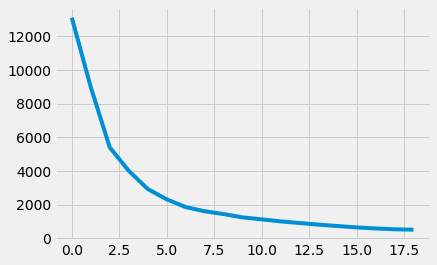

In [85]:
plt.plot(sse)
plt.show()

In [86]:
kmeans = KMeans(n_clusters=4,max_iter=400)
df['Labels']=kmeans.fit_predict(X)
df.head()

,CustomerID,Monetary,Frequency,Recnecy,Labels
0,12346.0,0.00,2,325,1
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,1


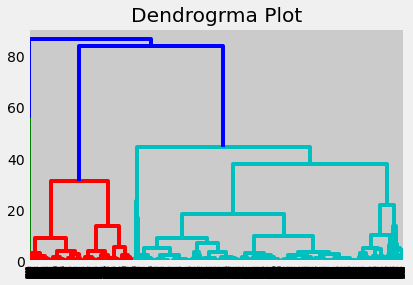

In [87]:
import scipy.cluster.hierarchy as shc  
dendro = shc.dendrogram(shc.linkage(X, method="ward"))  
plt.title("Dendrogrma Plot")  
plt.show()

In [90]:
from sklearn.cluster import AgglomerativeClustering  
hc= AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster_id= hc.fit_predict(X)
df['HC'] = cluster_id

In [91]:
df.head()

,CustomerID,Monetary,Frequency,Recnecy,Labels,HC
0,12346.0,0.00,2,325,1,2
1,12347.0,4310.00,182,1,0,1
2,12348.0,1797.24,31,74,0,1
3,12349.0,1757.55,73,18,0,1
4,12350.0,334.40,17,309,1,2
